In [1]:
##### Libraries #####
# import dotenv
# dotenv.load_dotenv(".env")
import os
import time
import utils
import shutil
import argparse
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)
tf.keras.utils.set_random_seed(0)
# import models_tensorflow.EEGModels
# from typing import Literal
from tensorflow.keras import backend
from tensorflow.keras import utils as tf_utils
backend.set_image_data_format("channels_last")
from sklearn.model_selection import train_test_split

import utils
from utils import Metric, plot_confusion_matrix, plot_history
from libs.dataset import BcicIv2aDataset, InnerSpeechDataset

## Load BCIC IV 2a Dataset 

In [2]:
os.environ["DATASET_DIR"] = 'datasets'

In [3]:
dataset = BcicIv2aDataset()  # l_freq=4
inputs, truths = dataset.all_data_and_label

Loading BCIC IV 2a dataset - A09E: 100%|████████| 18/18 [00:23<00:00,  1.31s/it]


In [4]:
print('inputs: ', inputs.shape)
print('truths: ', truths.shape)

inputs:  (5184, 22, 257)
truths:  (5184, 4)


## Prepare Inputs and Ground Truth Data

### Converting inputs to shape (batch_size, sequence_length, num_features)

In [5]:
inputs = np.transpose(inputs, (0, 2, 1))
print(inputs.shape)

(5184, 257, 22)


## Normalize data

In [6]:
# Normalize data for consistency
# noisy_inputs = (noisy_inputs - np.min(noisy_inputs)) / (np.max(noisy_inputs) - np.min(noisy_inputs))
inputs = (inputs - np.min(inputs)) / (np.max(inputs) - np.min(inputs))

In [7]:
from tensorflow.keras.utils import to_categorical

x_train = inputs
y_train_denoise = inputs
y_train_class = np.argmax(truths, axis=1) # Convert one-hot encoded truths to integer labels

# Assuming your class labels are integer encoded from 0 to 3
y_train_class = to_categorical(y_train_class, num_classes=4)

In [8]:
print('x_train shape: ', x_train.shape)
print('y_train_denoise shape: ', y_train_denoise.shape)
print('y_train_class shape: ', y_train_class.shape)


x_train shape:  (5184, 257, 22)
y_train_denoise shape:  (5184, 257, 22)
y_train_class shape:  (5184, 4)


## Build Transformer Autoencoder Model

We will build a Transformer style reconstruction model. The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. We needed to create a custom layer that performs the transpose operation within its call method.

## Define a Custom Layer for Transpose and Reshape

Define a custom Keras layer that will handle the transpose and reshape operations.

In [9]:
from tensorflow.keras.layers import Layer

class ReshapeAndTranspose(Layer):
    def __init__(self):
        super(ReshapeAndTranspose, self).__init__()

    def call(self, inputs):
        # Transpose the dimensions from (batch_size, sequence_length, num_features) to (batch_size, num_features, sequence_length)
        x = tf.transpose(inputs, perm=[0, 2, 1])
        # Add a channel dimension, which EEGNet expects
        x = tf.expand_dims(x, axis=-1)
        return x


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Layer normalization 1
    x = LayerNormalization(epsilon=1e-6)(inputs)
    # Multi-head attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    # Skip connection
    x = x + inputs
    # Layer normalization 2
    x = LayerNormalization(epsilon=1e-6)(x)
    # Feed-forward
    x_ff = Dense(ff_dim, activation='relu')(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    # Dropout and skip connection
    x = Dropout(dropout)(x_ff) + x
    return x


In [11]:
# Define the Transformer model for denoising
inputs = Input(shape=x_train.shape[1:]) #(257, 22)
x = transformer_encoder(inputs, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)
x = Dense(x_train.shape[-1], activation='linear')(x)
# Use the custom layer to reshape and transpose
reshaped_output = ReshapeAndTranspose()(x)

transformer_model = Model(inputs, reshaped_output)
transformer_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 257, 22)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 257, 22)   │         44 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 257, 22)   │     23,318 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 257, 22)   │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 257, 256)  │      5,888 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 257, 22)   │      5,654 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 257, 22)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 257, 22)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 257, 22)   │        506 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_and_transp… │ (None, 22, 257,   │          0 │ dense_2[0][0]     │
│ (ReshapeAndTranspo… │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,454 (138.49 KB)

 Trainable params: 35,454 (138.49 KB)

 Non-trainable params: 0 (0.00 B)

To DO:
We plan to jointly train this Transformer Denoiser network with EEGNet using a joint Loss function: Reconstruction loss for Denoiser + BCE loss for classification. 

Training standalone Transformer on reconstruction task is not necessary unless to make sure it's working. Fine tuning model hyperparameters and architecture has to be performed jointly on Transformer(Denoiser) + EEGNet pipeline, with frozen weights for EEGNet. 

Immediate task: Train the EEGNet by running necessary scripts and save the model weights, as they are currently missing. 

Next, import the EEGNet model from python script as a library into the Transformer notebook, instantiate the model, load the weights, and make trainable=False to freeze the weights. 

Then, build the pipeline of Transformer + EEGNet and optimize(train) the Transformer model using the joint loss function. 

Finally, write this as a script.

Note: For Transformer architecture, you can use classical time encoding methods or use learning methods like time2vec with trainable weights

Note: You can either design the Denoiser as an offset producer (have a skip connection from input and subtract it with pre-final output to effectively output the offset requiret to Denoise EEG data. OR view the Denoiser as a signal enhancer that will produce a cleaner version of raw signal with only important features, removing irrelevant details.

**Tasks:**

Build Three types of Autoencoders: CNN, LSTM, Transformers, compare their performance (as a signal reconstruction prpoblem - denoinsing task) and present results in final paper. Continue using the best performing model in building end-to-end training pipeline along with EEGNet.

Note the number of trainable parameters also, in each model!

## Load EEGNet

Next, import the EEGNet model from python script as a library into the Transformer notebook, instantiate the model, load the weights, and make trainable=False to freeze the weights. 

Then, build the pipeline of Transformer + EEGNet and optimize(train) the Transformer model using the joint loss function. 

Finally, write this as a script.

In [12]:
from histories.EEGNet_train_res.EEGModels import EEGNet

In [13]:
# Load EEGNet with the specified architecture parameters
eegnet_model = EEGNet(nb_classes=4, Chans=x_train.shape[2], Samples=x_train.shape[1],
                dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16,
                dropoutType="Dropout")


# Load model weights from file
model_filepath = '/Users/rishienandhan/Documents/GitHub/Preprocessor-for-EEG-Signals/histories/EEGNet_train_res/best_val_acc.h5'
eegnet_model.load_weights(model_filepath)

# Freeze EEGNet weights
eegnet_model.trainable = False

# Show the model architecture
eegnet_model.summary()


/Users/rishienandhan/miniforge3/envs/eeg/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 22, 257, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 22, 257, 8)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 22, 257, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 1, 257, 16)     │           352 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 257, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1, 257, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 1, 64, 16)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 64, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 1, 64, 16)      │           512 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 64, 16)      │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1, 64, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 1, 8, 16)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,796 (7.02 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,796 (7.02 KB)

## Define a Joint Model

Combine the EEGNet and Transformer in a single model to compute the joint loss.

In [14]:
# Feed the reshaped output into EEGNet
classification_output = eegnet_model(reshaped_output)

# Create the joint model
joint_model = Model(inputs, [x, classification_output])

# Define the joint loss function and compile the model
def joint_loss(y_true, y_pred):
    # Assuming y_true and y_pred are passed as lists of tensors [y_true_denoise, y_true_class] and [y_pred_denoise, y_pred_class]
    mse_loss = MeanSquaredError()
    bce_loss = BinaryCrossentropy()
    # Calculate MSE loss for the denoised output
    denoise_loss = mse_loss(y_true[0], y_pred[0])
    # Calculate BCE loss for the classification output
    class_loss = bce_loss(y_true[1], y_pred[1])
    # Combine losses
    return denoise_loss + class_loss # Adjust weighting as needed

joint_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 257, 22)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 257, 22)   │         44 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 257, 22)   │     23,318 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 257, 22)   │          0 │ multi_head_atten… │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 257, 22)   │         44 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 257, 256)  │      5,888 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 257, 22)   │      5,654 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 257, 22)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 257, 22)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 257, 22)   │        506 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_and_transp… │ (None, 22, 257,   │          0 │ dense_2[0][0]     │
│ (ReshapeAndTranspo… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 4)         │      1,796 │ reshape_and_tran… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,250 (145.51 KB)

 Trainable params: 35,454 (138.49 KB)

 Non-trainable params: 1,796 (7.02 KB)

## Train the Joint Model

This setup allows us to optimize the Transformer model for denoising while leveraging the pre-trained, frozen EEGNet for classification, integrating their performance through a joint training process.

In [15]:
print('x_train shape: ', x_train.shape)
print('y_train_denoise shape: ', y_train_denoise.shape)
print('y_train_class shape: ', y_train_class.shape)


x_train shape:  (5184, 257, 22)
y_train_denoise shape:  (5184, 257, 22)
y_train_class shape:  (5184, 4)


In [16]:
import numpy as np
from sklearn.model_selection import train_test_split

def split_data(x_train, y_train_denoise, y_train_class, test_size=0.2, random_state=42):
    # Generate shuffled indices
    num_samples = len(x_train)
    indices = np.arange(num_samples)
    np.random.seed(random_state)
    np.random.shuffle(indices)

    # Apply shuffling to all arrays
    x_train_shuffled = x_train[indices]
    y_train_denoise_shuffled = y_train_denoise[indices]
    y_train_class_shuffled = y_train_class[indices]

    # Split shuffled data into training and testing sets
    x_train_split, x_test_split, y_train_denoise_split, y_test_denoise_split, y_train_class_split, y_test_class_split = train_test_split(
        x_train_shuffled, y_train_denoise_shuffled, y_train_class_shuffled, test_size=test_size, random_state=random_state
    )

    return x_train_split, x_test_split, y_train_denoise_split, y_test_denoise_split, y_train_class_split, y_test_class_split


## Create train and val split 

In [17]:
x_train, x_val, y_train_denoise, y_val_denoise, y_train_class, y_val_class = split_data(
    x_train, y_train_denoise, y_train_class
)

In [18]:
print('x_train shape: ', x_train.shape)
print('y_train_denoise shape: ', y_train_denoise.shape)
print('y_train_class shape: ', y_train_class.shape)

print('x_val shape: ', x_val.shape)
print('y_val_denoise shape: ', y_val_denoise.shape)
print('y_val_class shape: ', y_val_class.shape)


x_train shape:  (4147, 257, 22)
y_train_denoise shape:  (4147, 257, 22)
y_train_class shape:  (4147, 4)
x_val shape:  (1037, 257, 22)
y_val_denoise shape:  (1037, 257, 22)
y_val_class shape:  (1037, 4)


## Setup a Custom Training Loop

Note: This setup allows us to track the MSE and BCE losses separately along with the total loss. This information is crucial for diagnosing the performance of different aspects of the joint model, enabling us to understand how well the denoising and classification components are learning and interacting during training.

In [19]:
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean, CategoricalAccuracy

# Loss functions
mse_loss = MeanSquaredError()
cce_loss = CategoricalCrossentropy()

# Metrics for training
train_loss = tf.keras.metrics.Mean(name='train_loss')
mse_train_metric = tf.keras.metrics.Mean(name='train_mse_loss')
cce_train_metric = tf.keras.metrics.Mean(name='train_cce_loss')

# Metrics for validation
validation_loss = tf.keras.metrics.Mean(name='validation_loss')
mse_validation_metric = tf.keras.metrics.Mean(name='validation_mse_loss')
cce_validation_metric = tf.keras.metrics.Mean(name='validation_cce_loss')

# Accuracy metric for validation
validation_accuracy = tf.keras.metrics.CategoricalAccuracy(name='validation_accuracy')


In [20]:
# using Adam optimizer
optimizer = Adam(learning_rate=1e-3) # Using Adam optimizer

In [21]:
@tf.function
def train_step(model, x_batch, y_true_denoise, y_true_class):
    with tf.GradientTape() as tape:
        y_pred_denoise, y_pred_class = model(x_batch, training=True)
        mse = mse_loss(y_true_denoise, y_pred_denoise)
        cce = cce_loss(y_true_class, y_pred_class)
        loss = mse + cce
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss.update_state(loss)
    mse_train_metric.update_state(mse)
    cce_train_metric.update_state(cce)

In [22]:
@tf.function
def val_step(model, x_batch, y_true_denoise, y_true_class):
    y_pred_denoise, y_pred_class = model(x_batch, training=False)
    mse = mse_loss(y_true_denoise, y_pred_denoise)
    cce = cce_loss(y_true_class, y_pred_class)
    loss = mse + cce
    validation_loss.update_state(loss)
    mse_validation_metric.update_state(mse)
    cce_validation_metric.update_state(cce)
    validation_accuracy.update_state(y_true_class, y_pred_class)


In [23]:
epochs = 10
batch_size = 32

for epoch in range(epochs):
    # Reset metrics at the start of each epoch
    train_loss.reset_state()
    mse_train_metric.reset_state()
    cce_train_metric.reset_state()
    validation_loss.reset_state()
    mse_validation_metric.reset_state()
    cce_validation_metric.reset_state()
    validation_accuracy.reset_state()

    # Training loop
    for i in range(0, len(x_train), batch_size):
        batch_x = x_train[i:i+batch_size]
        batch_y_denoise = y_train_denoise[i:i+batch_size]
        batch_y_class = y_train_class[i:i+batch_size]
        train_step(joint_model, batch_x, batch_y_denoise, batch_y_class)

    # Validation loop
    for i in range(0, len(x_val), batch_size):
        batch_x = x_val[i:i+batch_size]
        batch_y_denoise = y_val_denoise[i:i+batch_size]
        batch_y_class = y_val_class[i:i+batch_size]
        val_step(joint_model, batch_x, batch_y_denoise, batch_y_class)

    # Print the results
    print(f"Epoch {epoch + 1}, Total Loss: {train_loss.result()}, MSE Loss: {mse_train_metric.result()}, CCE Loss: {cce_train_metric.result()}")
    print(f"Validation Total Loss: {validation_loss.result()}, Validation MSE Loss: {mse_validation_metric.result()}, Validation CCE Loss: {cce_validation_metric.result()}, Validation Accuracy: {validation_accuracy.result().numpy()}")


Epoch 1, Total Loss: 58825.296875, MSE Loss: 1.5025264024734497, CCE Loss: 58823.79296875
Validation Total Loss: 6956.9453125, Validation MSE Loss: 1.2590603828430176, Validation CCE Loss: 6955.6865234375, Validation Accuracy: 0.34908390045166016
Epoch 2, Total Loss: 11811.1826171875, MSE Loss: 1.0872459411621094, CCE Loss: 11810.0966796875
Validation Total Loss: 6477.33056640625, Validation MSE Loss: 1.0220500230789185, Validation CCE Loss: 6476.3076171875, Validation Accuracy: 0.3355834186077118
Epoch 3, Total Loss: 9382.994140625, MSE Loss: 0.9819902181625366, CCE Loss: 9382.0087890625
Validation Total Loss: 4924.96630859375, Validation MSE Loss: 0.9561927318572998, Validation CCE Loss: 4924.00927734375, Validation Accuracy: 0.33654773235321045
Epoch 4, Total Loss: 4982.015625, MSE Loss: 0.9017552733421326, CCE Loss: 4981.1162109375
Validation Total Loss: 2605.9619140625, Validation MSE Loss: 0.8810320496559143, Validation CCE Loss: 2605.0810546875, Validation Accuracy: 0.3307618200

In [24]:
import matplotlib.pyplot as plt

def plot_original_and_denoised_eeg(original_data, denoised_data, channel_indices=[0], time_range=None, sample_index=0):
    """
    Plots comparison of original EEG data and denoised output from the transformer model.

    Parameters:
    - original_data: numpy array of shape (batch_size, sequence_length, num_features), original EEG data (ground truth).
    - denoised_data: numpy array of the same shape, model's prediction (denoised output).
    - channel_indices: list of integers, indices of the channels to plot.
    - time_range: tuple of (start, end), range of time steps to plot. Defaults to the full range.
    - sample_index: integer, index of the sample from the dataset to plot.
    """
    # Define the time range to plot if not specified
    if time_range is None:
        time_range = (0, original_data.shape[1])  # Use the full range of time steps
    
    num_plots = len(channel_indices)
    fig, axes = plt.subplots(num_plots, 1, figsize=(14, 3 * num_plots), squeeze=False)
    
    # Iterate over each specified channel index
    for i, channel_idx in enumerate(channel_indices):
        ax = axes[i][0]
        # Plot the original and the denoised data for each channel
        ax.plot(original_data[sample_index, time_range[0]:time_range[1], channel_idx], label='Original EEG', color='blue')
        ax.plot(denoised_data[sample_index, time_range[0]:time_range[1], channel_idx], label='Denoised EEG', color='green')
        
        ax.set_title(f'EEG Channel {channel_idx + 1} Comparison')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Amplitude')
        ax.legend()

    plt.tight_layout()
    plt.show()


In [25]:
# make predictions after model training:
y_pred_denoise, y_pred_class = joint_model(x_val, training=False)

In [26]:
y_pred_class.shape

TensorShape([1037, 4])

In [27]:
y_val_class.shape

(1037, 4)

In [28]:
import tensorflow as tf

def compute_classification_accuracy(y_true, y_pred):
    """
    Computes the classification accuracy given the true labels and the predicted labels.
    
    Parameters:
    - y_true: numpy array or TensorFlow tensor, true labels (one-hot encoded)
    - y_pred: numpy array or TensorFlow tensor, predicted labels (probabilities or one-hot encoded)
    
    Returns:
    - accuracy: float, the computed categorical accuracy
    """
    # Initialize the CategoricalAccuracy metric
    accuracy_metric = tf.keras.metrics.CategoricalAccuracy()

    # Update the metric with the true labels and predicted labels
    accuracy_metric.update_state(y_true, y_pred)

    # Retrieve and return the result as a float
    return accuracy_metric.result().numpy()


In [29]:
# compute overall accuracy
accuracy = compute_classification_accuracy(y_val_class, y_pred_class)
print(f"Overall classification accuracy: {accuracy:.4f}")


Overall classification accuracy: 0.3481


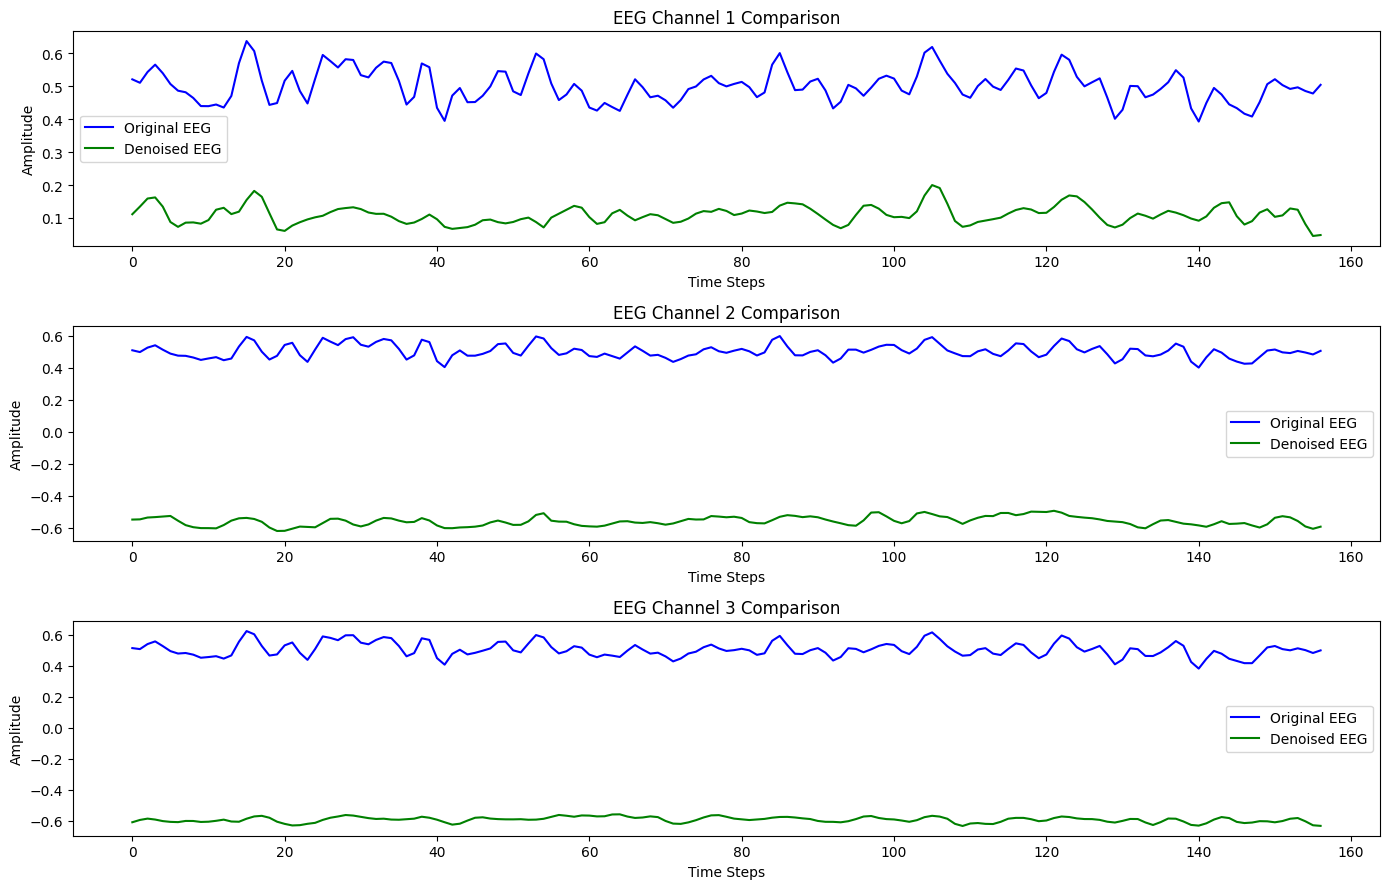

In [30]:
# We can choose which channels to display and what portion of the data you want to visualize
plot_original_and_denoised_eeg(
    original_data=x_val,
    denoised_data=y_pred_denoise,
    channel_indices=[0, 1, 2],  # Example: Channels 1, 2, and 3
    time_range=(100, 300),      # Example: From time step 100 to 300
    sample_index=0              # Example: First sample in the batch
)
